In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as ticker
import squarify
from wordcloud import WordCloud

import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import chi2_contingency
from scipy.stats import norm, skew, kurtosis

import statsmodels.api as sm
import statsmodels.formula.api as smf

## 1. Load File

In [2]:
# Specify the file path
file_path = 'C:/Users/domin/Documents/GitHub/xai_budgeting/001_data/003_experiment/001_budget/118_qualtrics_results.csv' 

# Load the .csv file into a DataFrame
qualtrics_results_df = pd.read_csv(file_path)
qualtrics_results_df.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Scenario1_FinalAnswer
0,08/03/2024 15:37,08/03/2024 15:45,IP Address,109.255.101.29,100,509,True,08/03/2024 15:45,R_42EVTwsQNiMtYLs,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179330
1,08/03/2024 15:40,08/03/2024 15:48,IP Address,90.211.114.152,100,500,True,08/03/2024 15:49,R_7Lh4y2eZkgRZuZl,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160295
2,08/03/2024 15:40,08/03/2024 15:49,IP Address,82.40.42.60,100,539,True,08/03/2024 15:49,R_7mVlSS7HbwxkyXJ,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,161903
3,08/03/2024 15:43,08/03/2024 15:50,IP Address,205.250.119.206,100,400,True,08/03/2024 15:50,R_5WPAWGujRgpokUh,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162440
4,08/03/2024 15:45,08/03/2024 15:50,IP Address,86.145.73.224,100,274,True,08/03/2024 15:50,R_8odLgQVMrpe7TpX,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160027


## 2. General Survey Stats

#### Survey Participation

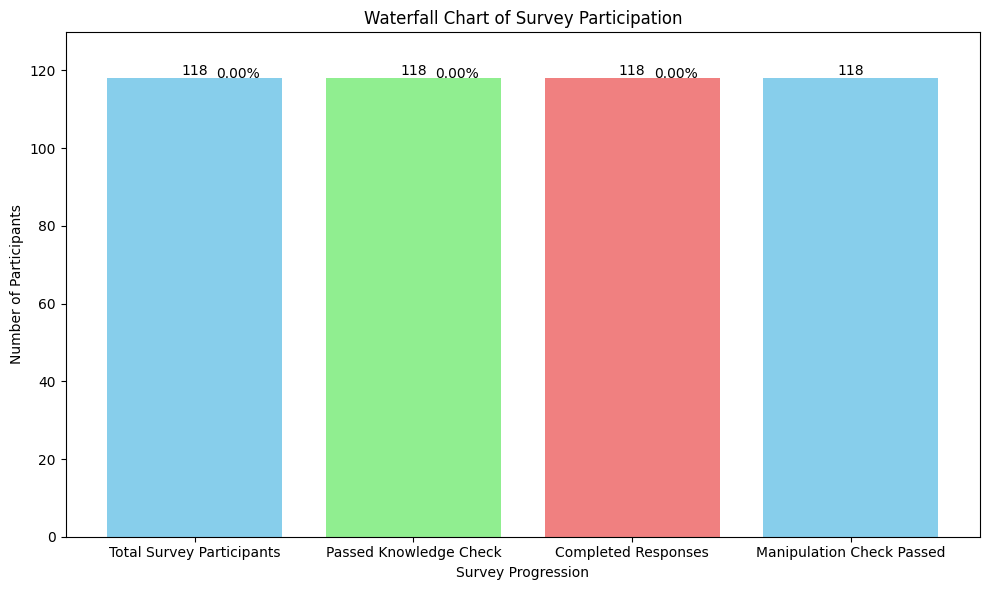

In [3]:
# Assuming qualtrics_results_df is already defined and the first two rows are skipped
qualtrics_results_df_adjusted = qualtrics_results_df

# Calculate counts for each step
total_survey_participants = (qualtrics_results_df_adjusted["Consent"] == "Yes, I consent to participate").sum()
qualified_participants = qualtrics_results_df_adjusted["Scenario1_Answer_1"].notna().sum()
completed_responses = qualtrics_results_df_adjusted["Manip_Check"].notna().sum()

# Define the filtering conditions as previously described
condition_1 = (qualtrics_results_df_adjusted['FL_23_DO'] == 'FL_74') & \
              (qualtrics_results_df_adjusted['Manip_Check'] == "Yes")

condition_2 = (qualtrics_results_df_adjusted['FL_23_DO'] == 'FL_76') & \
              (qualtrics_results_df_adjusted['Manip_Check'] == "No") 

# Combine conditions using the logical OR operator
final_condition = condition_1 | condition_2

# Filter the DataFrame and count rows that match the condition
filtered_rows_count = qualtrics_results_df_adjusted[final_condition].shape[0]

# Data for plotting
steps = ['Total Survey Participants', 'Passed Knowledge Check', 'Completed Responses', 'Manipulation Check Passed']
values = [total_survey_participants, qualified_participants, completed_responses, filtered_rows_count]

# Calculate percentage changes
percentage_changes = [0]  # No change for the first element
for i in range(1, len(values)):
    change = ((values[i] - values[i-1]) / values[i-1]) * 100 if values[i-1] else 0
    percentage_changes.append(change)

# Start plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each step
bars = plt.bar(steps, values, color=['skyblue', 'lightgreen', 'lightcoral'])

# Adding value labels on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{values[i]}', ha='center', va='bottom')

# Adding percentage change annotations between bars
for i in range(1, len(bars)):
    start_height = bars[i-1].get_height()
    end_height = bars[i].get_height()
    # Position the annotation in the middle of the two bars vertically
    middle_height = start_height + (end_height - start_height) / 2
    plt.text(bars[i].get_x() - bars[i].get_width() / 2.0, middle_height, f'{percentage_changes[i]:.2f}%', ha='center', color='black')

# Customizing the plot
plt.xlabel('Survey Progression')
plt.ylabel('Number of Participants')
plt.title('Waterfall Chart of Survey Participation')
plt.xticks(steps)
plt.ylim(0, max(values) + max(values) * 0.1)  # Adjust y-limit to accommodate annotations

plt.tight_layout()
plt.show()


#### Save Dataset with completed results

In [4]:
# Save the df with all completed surveys
completed_survey_df = qualtrics_results_df.loc[qualtrics_results_df['Manip_Check'].notna()]

In [5]:
# Restrict df to responses that passed the manipulation test only
condition_1 = (qualtrics_results_df_adjusted['FL_23_DO'] == 'FL_74') & \
              (qualtrics_results_df_adjusted['Manip_Check'] == "Yes")

condition_2 = (qualtrics_results_df_adjusted['FL_23_DO'] == 'FL_76') & \
              (qualtrics_results_df_adjusted['Manip_Check'] == "No") 

# Combine conditions using the logical OR operator
final_condition = condition_1 | condition_2

# Filter the DataFrame
completed_survey_df = completed_survey_df[final_condition]
completed_survey_df.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Scenario1_FinalAnswer
0,08/03/2024 15:37,08/03/2024 15:45,IP Address,109.255.101.29,100,509,True,08/03/2024 15:45,R_42EVTwsQNiMtYLs,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,179330
1,08/03/2024 15:40,08/03/2024 15:48,IP Address,90.211.114.152,100,500,True,08/03/2024 15:49,R_7Lh4y2eZkgRZuZl,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160295
2,08/03/2024 15:40,08/03/2024 15:49,IP Address,82.40.42.60,100,539,True,08/03/2024 15:49,R_7mVlSS7HbwxkyXJ,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,161903
3,08/03/2024 15:43,08/03/2024 15:50,IP Address,205.250.119.206,100,400,True,08/03/2024 15:50,R_5WPAWGujRgpokUh,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162440
4,08/03/2024 15:45,08/03/2024 15:50,IP Address,86.145.73.224,100,274,True,08/03/2024 15:50,R_8odLgQVMrpe7TpX,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160027


In [6]:
# Define Final Answer
completed_survey_df['Scenario1_FinalAnswer'] = completed_survey_df.apply(
    lambda row: row['AI_Resubmission13_1'] if pd.notna(row['AI_Resubmission13_1']) else 
                (row['NoAI_Resubmission13_1'] if pd.notna(row['NoAI_Resubmission13_1']) else row['Scenario1_Answer_1']), axis=1)

# Display the first few rows to verify the new columns
print(completed_survey_df[['Scenario1_FinalAnswer']].head())


   Scenario1_FinalAnswer
0               179330.0
1               160295.0
2               161903.0
3               162440.0
4               160027.0


In [7]:
#Calculate Final Value

completed_survey_df['Scenario1_FinalAnswer'] = pd.to_numeric(completed_survey_df['Scenario1_FinalAnswer'], errors='coerce')
completed_survey_df['Scenario1_Answer_1'] = pd.to_numeric(completed_survey_df['Scenario1_Answer_1'], errors='coerce')


In [8]:
# # Save DataFrame to CSV
# csv_file_path = 'C:/Users/domin/Documents/GitHub/xai_budgeting/001_data/003_experiment/001_budget/final_qualtrics_results.csv'
# completed_survey_df.to_csv(csv_file_path, index=False)

#### Survey duration

In [9]:
# Ensure the "Duration (in seconds)" column is treated as numeric, coercing errors to NaN
completed_survey_df["Duration (in seconds)"] = pd.to_numeric(completed_survey_df["Duration (in seconds)"], errors='coerce')

# Check if conversion was successful; if so, convert "Duration (in seconds)" to minutes
if completed_survey_df["Duration (in seconds)"].dtype == 'float64' or completed_survey_df["Duration (in seconds)"].dtype == 'int64':
    completed_survey_df["Duration (in minutes)"] = completed_survey_df["Duration (in seconds)"] / 60
    # Calculate summary statistics for "Duration (in minutes)" and display as DataFrame
    duration_stats_df = pd.DataFrame(completed_survey_df["Duration (in minutes)"].describe())
    print(duration_stats_df)
else:
    print("Conversion to numeric type was unsuccessful. Please check the data for non-numeric values.")


       Duration (in minutes)
count             118.000000
mean               10.510452
std                 5.461616
min                 3.383333
25%                 6.833333
50%                 8.941667
75%                13.012500
max                32.700000


In [10]:
# Ensure the "Duration (in seconds)" column is treated as numeric
completed_survey_df["Duration (in seconds)"] = pd.to_numeric(completed_survey_df["Duration (in seconds)"], errors='coerce')

# Now, print summary statistics for "Duration (in seconds)"
print(completed_survey_df["Duration (in seconds)"].describe())


count     118.000000
mean      630.627119
std       327.696983
min       203.000000
25%       410.000000
50%       536.500000
75%       780.750000
max      1962.000000
Name: Duration (in seconds), dtype: float64


#### Distribution of Manipulations

Total

In [11]:
# Count rows with "FL_23_DO" value = FL_74
count_fl_74 = (completed_survey_df["FL_23_DO"] == "FL_74").sum()

# Count rows with "FL_23_DO" value = FL_76
count_fl_76 = (completed_survey_df["FL_23_DO"] == "FL_76").sum()

# Display the counts
print("FL_74 count:", count_fl_74) # AI Condition
print("FL_76 count:", count_fl_76) # Non-AI Condition


FL_74 count: 55
FL_76 count: 63


## 3. Demographic Data (Source: Prolific)

#### Load File and limit to participants who passed Manipulation Check

In [12]:
# Specify the file path
file_path = 'C:/Users/domin/Documents/GitHub/xai_budgeting/001_data/003_experiment/001_budget/all_prolific_results.csv'

# Load the .csv file into a DataFrame
demographics_df = pd.read_csv(file_path)
demographics_df.head()

,Submission id,Participant id,Status,Custom study tncs accepted at,Started at,Completed at,Reviewed at,Archived at,Time taken,Completion code,...,Highest education level completed,Age,Sex,Ethnicity simplified,Country of birth,Country of residence,Nationality,Language,Student status,Employment status
0,65eb22918dd7dad3b69bf52c,5d801d303f019e001804c468,AWAITING REVIEW,Not Applicable,2024-03-08T14:37:23.124000Z,2024-03-08T14:45:59.089000Z,NaN,2024-03-08T14:45:59.712100Z,516,C21PHUAV,...,Undergraduate degree (BA/BSc/other),28,Female,White,Ireland,Ireland,Ireland,English,Yes,Other
1,65eb22a8edf08f40789933c3,6568a71084a6f597c4f0e887,AWAITING REVIEW,Not Applicable,2024-03-08T14:37:28.407000Z,2024-03-08T14:38:46.197000Z,NaN,2024-03-08T14:38:46.731039Z,78,C21PHUAV,...,Undergraduate degree (BA/BSc/other),27,Female,Other,Turkey,Australia,Turkey,Turkish,Yes,Part-Time
2,65eb22bce04c0cede778a562,5ae781e5efcc690001ebf022,AWAITING REVIEW,Not Applicable,2024-03-08T14:37:58.253000Z,2024-03-08T14:51:08.671000Z,NaN,2024-03-08T14:51:09.226761Z,791,C21PHUAV,...,Undergraduate degree (BA/BSc/other),37,Female,White,Croatia,United Kingdom,Croatia,Croatian,No,Full-Time
3,65eb2337a47849fca886e98b,6571ed82ff0be0217f88ea79,AWAITING REVIEW,Not Applicable,2024-03-08T14:46:24.847000Z,2024-03-08T15:05:06.758000Z,NaN,2024-03-08T15:05:07.201505Z,1122,C21PHUAV,...,Undergraduate degree (BA/BSc/other),29,Female,Black,Nigeria,United Kingdom,Nigeria,English,Yes,Part-Time
4,65eb233d05812e2727637d59,5eb126c5f13db7000855c7b7,AWAITING REVIEW,Not Applicable,2024-03-08T14:40:01.290000Z,2024-03-08T14:49:10.990000Z,NaN,2024-03-08T14:49:11.452457Z,550,C21PHUAV,...,Graduate degree (MA/MSc/MPhil/other),28,Female,White,United Kingdom,United Kingdom,United Kingdom,English,Yes,Full-Time


In [13]:
# Filter demographics_df to include only rows where "Participant id" is present in "PROLIFIC_PID" of completed_survey_df
filtered_demographics_df = demographics_df[demographics_df["Participant id"].isin(completed_survey_df["PROLIFIC_PID"])]
len(filtered_demographics_df)

118

#### Create Charts summarizing the sample

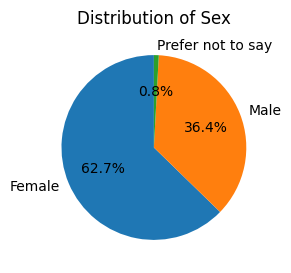

In [14]:
# Count the occurrences of each unique value in the "Sex" column
sex_counts = filtered_demographics_df['Sex'].value_counts()

# Plot the pie chart
plt.figure(figsize=(3, 3))  # Optional: Adjust the figure size as needed
sex_counts.plot.pie(autopct='%1.1f%%', startangle=90)  # autopct shows the percentage on the chart

plt.title('Distribution of Sex')  # Add a title to the pie chart
plt.ylabel('')  # Remove the y-axis label to clean up the chart appearance
plt.show()


In [15]:
# Count the total number of entries for calculating percentages
total_count = sex_counts.sum()

# Calculating percentages
sex_percentages = sex_counts / total_count * 100

# For simplicity and assuming "Prefer not to say" falls into "Other", if not already in your data
# You might need to adjust the categories based on your actual data distribution
if 'Male' not in sex_percentages:
    sex_percentages['Male'] = 0
if 'Female' not in sex_percentages:
    sex_percentages['Female'] = 0
if 'Other' not in sex_percentages:
    # This aggregates any category not explicitly labeled as 'Male' or 'Female'
    other_categories = ['Prefer not to say', 'Non-binary', 'Other']
    other_count = sum(filtered_demographics_df['Sex'].isin(other_categories))
    sex_percentages['Other'] = other_count / total_count * 100

# Print results
for sex, count in sex_counts.items():
    print(f"{sex}: \t\t{count} ({sex_percentages[sex]:.0f}%)")


Female: 		74 (63%)
Male: 		43 (36%)
Prefer not to say: 		1 (1%)


In [16]:
# Define the age bins and labels
bins = [0, 24, 35, 51, 66, float('inf')]
labels = ['18–24 years', '25–34 years', '35–50 years', '51–65 years', '65+ years']

# Categorize ages into bins using pd.cut and create a new column for this categorization
# Using .loc ensures that the operation is done in place and avoids SettingWithCopyWarning
filtered_demographics_df['Age Group'] = pd.cut(filtered_demographics_df['Age'], bins=bins, labels=labels, right=False)

# Count the absolute numbers in each age group
age_group_counts = filtered_demographics_df['Age Group'].value_counts().reindex(labels, fill_value=0)

# Calculate total for percentages
total_count = age_group_counts.sum()

# Calculate percentages
age_group_percentages = age_group_counts / total_count * 100

# Print results in the specified format
for age_group in labels:
    print(f"{age_group}: \t{age_group_counts[age_group]} ({age_group_percentages[age_group]:.0f}%)")


18–24 years: 	5 (4%)
25–34 years: 	38 (32%)
35–50 years: 	46 (39%)
51–65 years: 	24 (20%)
65+ years: 	5 (4%)


C:\Users\domin\AppData\Local\Temp\ipykernel_31428\1214720847.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_demographics_df['Age Group'] = pd.cut(filtered_demographics_df['Age'], bins=bins, labels=labels, right=False)


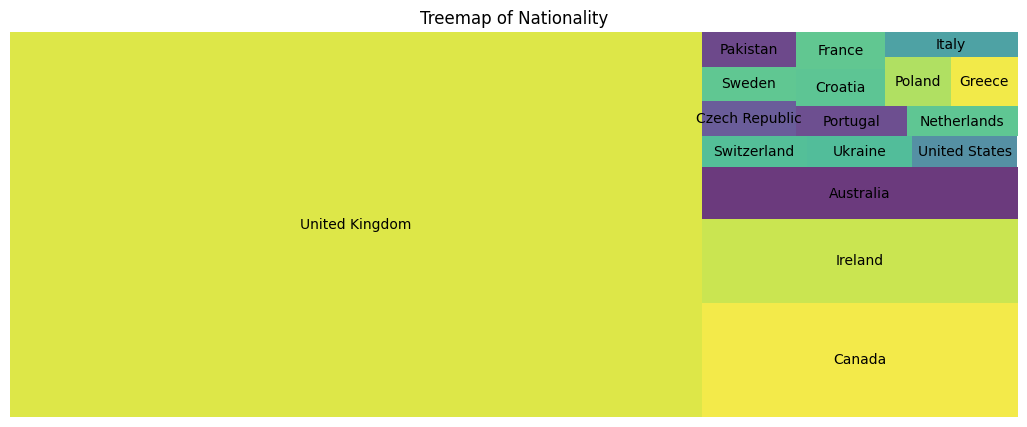

In [17]:
# Calculate the frequency of each nationality
nationality_counts = filtered_demographics_df['Nationality'].value_counts()

# Prepare data for the treemap
sizes = nationality_counts.values
label = nationality_counts.index

# Create the treemap
plt.figure(figsize=(13, 5))
squarify.plot(sizes=sizes, label=label, alpha=0.8)

# Additional plot aesthetics
plt.title('Treemap of Nationality')
plt.axis('off')  # Removes the axes for a cleaner look
plt.show()


In [55]:
# Display absolute count
filtered_demographics_df['Nationality'].value_counts()


Nationality
United Kingdom    81
Canada            11
Ireland            8
Australia          5
Switzerland        1
Ukraine            1
United States      1
Czech Republic     1
Sweden             1
Pakistan           1
Portugal           1
Netherlands        1
Croatia            1
France             1
Poland             1
Greece             1
Italy              1
Name: count, dtype: int64

In [56]:
filtered_demographics_df['Nationality'].value_counts(normalize=True)

Nationality
United Kingdom    0.686441
Canada            0.093220
Ireland           0.067797
Australia         0.042373
Switzerland       0.008475
Ukraine           0.008475
United States     0.008475
Czech Republic    0.008475
Sweden            0.008475
Pakistan          0.008475
Portugal          0.008475
Netherlands       0.008475
Croatia           0.008475
France            0.008475
Poland            0.008475
Greece            0.008475
Italy             0.008475
Name: proportion, dtype: float64

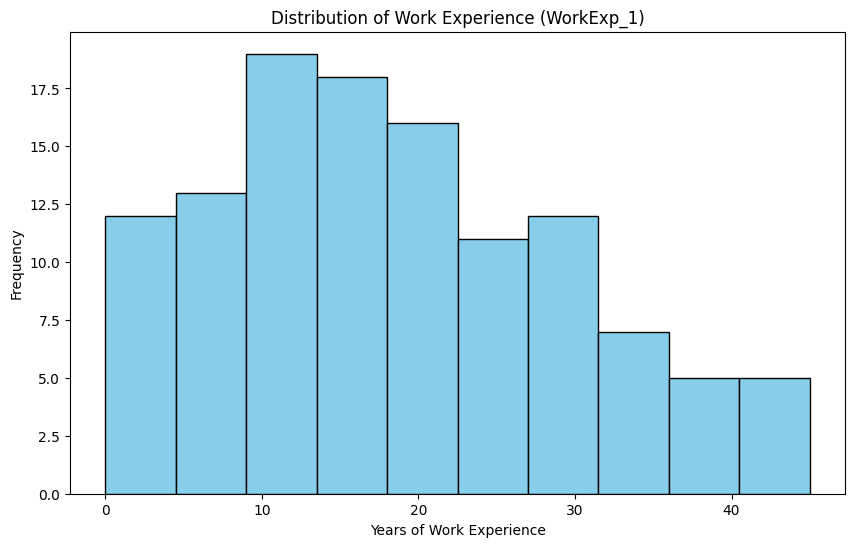

In [18]:
# Ensure "WorkExp_1" is in a numeric format
completed_survey_df['WorkExp_1'] = pd.to_numeric(completed_survey_df['WorkExp_1'], errors='coerce')

# Create the histogram
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.hist(completed_survey_df['WorkExp_1'].dropna(), bins=10, color='skyblue', edgecolor='black')

# Add titles and labels
plt.title('Distribution of Work Experience (WorkExp_1)')
plt.xlabel('Years of Work Experience')
plt.ylabel('Frequency')

# Show the plot
plt.show()


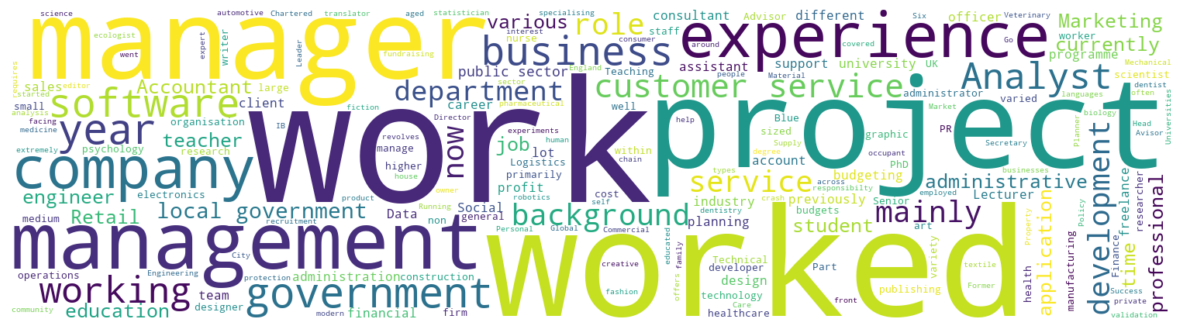

In [19]:
# Concatenate all text from the "Your Background" column into a single string
text = ' '.join(description for description in completed_survey_df['Your Background'].dropna())

# Create a word cloud object
wordcloud = WordCloud(width=1500, height=400, background_color ='white').generate(text)

# Display the generated image
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Don't show axes to keep it clean
plt.show()


## 4. Descriptive Results

In [20]:
# Function to categorize work experience
def categorize_work_experience(years):
    if years < 1:
        return '< 1 year'
    elif 1 <= years <= 5:
        return '1–5 years'
    elif 6 <= years <= 10:
        return '6–10 years'
    else:  # For everything else, assuming it's > 10 years
        return '> 10 years'

# Apply the categorization function to each row in the 'WorkExp_1' column
# and create a new column for these categories
completed_survey_df['WorkExp_Category'] = completed_survey_df['WorkExp_1'].apply(categorize_work_experience)

# Count the absolute numbers in each work experience category
work_exp_counts = completed_survey_df['WorkExp_Category'].value_counts()

# Since the value_counts does not guarantee the order, we can reindex as per our categories
ordered_categories = ['< 1 year', '1–5 years', '6–10 years', '> 10 years']
work_exp_counts = work_exp_counts.reindex(ordered_categories, fill_value=0)

# Calculate total for percentages
total_count = work_exp_counts.sum()

# Calculate percentages
work_exp_percentages = work_exp_counts / total_count * 100

# Print results in the specified format
for category in ordered_categories:
    print(f"{category}: \t\t{work_exp_counts[category]} ({work_exp_percentages[category]:.0f}%)")


< 1 year: 		1 (1%)
1–5 years: 		14 (12%)
6–10 years: 		24 (20%)
> 10 years: 		79 (67%)


#### AI Condition

In [21]:
# Convert the scenario answer columns to numeric, using errors='coerce' to handle any non-numeric entries safely
completed_survey_df['Scenario1_Answer_1'] = pd.to_numeric(completed_survey_df['Scenario1_Answer_1'], errors='coerce')

In [22]:
# Filter the DataFrame for rows where "FL_23_DO" equals "FL_74"
aicon_df = completed_survey_df[completed_survey_df["FL_23_DO"] == "FL_74"]

Initial Submission

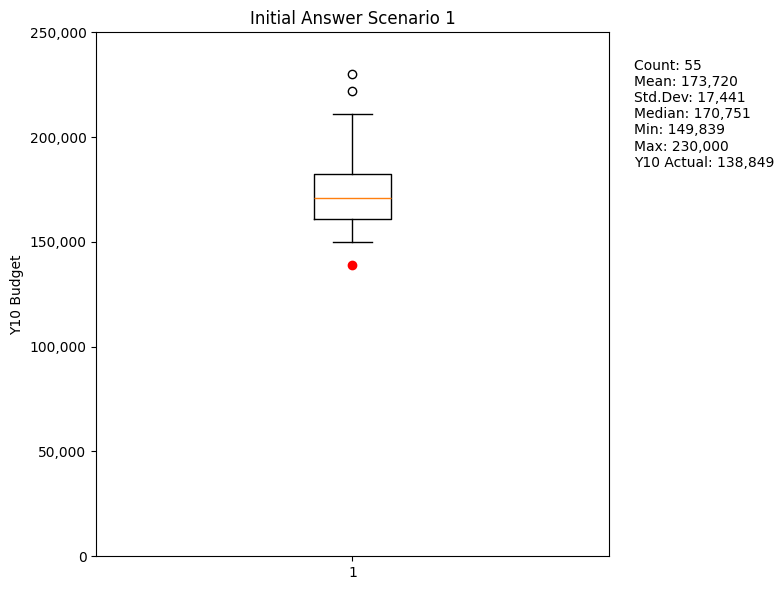

In [23]:
# Prepare data for boxplot
data_to_plot = [aicon_df['Scenario1_Answer_1'].dropna()]
red_dot_values = [138849]  # Specified value for the red dot in the boxplot
titles = ['Initial Answer Scenario 1']

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Generate the boxplot for Scenario 1
ax.boxplot(data_to_plot)
ax.set_title(titles[0])

# Calculate statistics
count = len(data_to_plot[0])
mean = np.mean(data_to_plot[0])
std_dev = np.std(data_to_plot[0], ddof=1)  # Sample standard deviation
median = np.median(data_to_plot[0])  # Median
min_val = np.min(data_to_plot[0])  # Minimum
max_val = np.max(data_to_plot[0])  # Maximum

# Annotate the plot with the calculated statistics, including median, min, max, and Y10 Actual Expenses
stats_text = f'Count: {count:,d}\nMean: {mean:,.0f}\nStd.Dev: {std_dev:,.0f}\nMedian: {median:,.0f}\nMin: {min_val:,.0f}\nMax: {max_val:,.0f}\nY10 Actual: {red_dot_values[0]:,d}'
ax.text(1.05, 0.95, stats_text, transform=ax.transAxes, verticalalignment='top')

# Add a red dot for the specified value
ax.plot(1, red_dot_values[0], 'ro', label='Actual Expense Y10')

# Set y-axis limits
ax.set_ylim(0, 250000)

# Format y-axis with ,000 separators
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}'))

# Add y-axis label
ax.set_ylabel('Y10 Budget')

# Create a custom legend for the red dot
# ax.legend(handles=[red_dot], loc="upper center", bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

plt.tight_layout()
plt.show()


Submission After Slack Evaluation

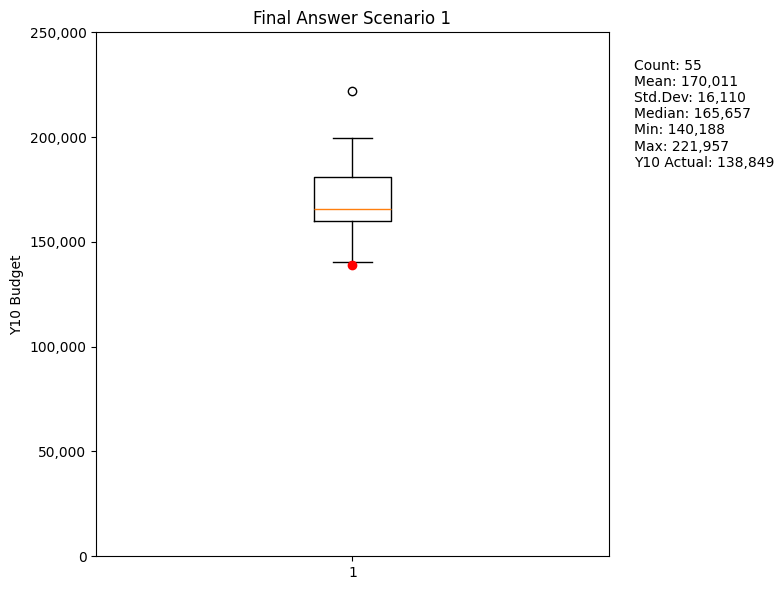

In [24]:
# Prepare data for boxplot
data_to_plot = [aicon_df['Scenario1_FinalAnswer'].dropna()]
red_dot_values = [138849]  # Specified value for the red dot in the boxplot
titles = ['Final Answer Scenario 1']

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Generate the boxplot for Scenario 1
ax.boxplot(data_to_plot)
ax.set_title(titles[0])

# Calculate statistics
count = len(data_to_plot[0])
mean = np.mean(data_to_plot[0])
std_dev = np.std(data_to_plot[0], ddof=1)  # Sample standard deviation
median = np.median(data_to_plot[0])  # Median
min_val = np.min(data_to_plot[0])  # Minimum
max_val = np.max(data_to_plot[0])  # Maximum

# Annotate the plot with the calculated statistics, including median, min, max, and Y10 Actual Expenses
stats_text = f'Count: {count:,d}\nMean: {mean:,.0f}\nStd.Dev: {std_dev:,.0f}\nMedian: {median:,.0f}\nMin: {min_val:,.0f}\nMax: {max_val:,.0f}\nY10 Actual: {red_dot_values[0]:,d}'
ax.text(1.05, 0.95, stats_text, transform=ax.transAxes, verticalalignment='top')

# Add a red dot for the specified value
ax.plot(1, red_dot_values[0], 'ro', label='Actual Expense Y10')

# Set y-axis limits
ax.set_ylim(0, 250000)

# Format y-axis with ,000 separators
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}'))

# Add y-axis label
ax.set_ylabel('Y10 Budget')

# Create a custom legend for the red dot
# ax.legend(handles=[red_dot], loc="upper center", bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

plt.tight_layout()
plt.show()


#### Non-AI Condition

In [25]:
# Filter the DataFrame for rows where "FL_23_DO" equals "FL_74"
nonaicon_df = completed_survey_df[completed_survey_df["FL_23_DO"] == "FL_76"]

Initial Submission

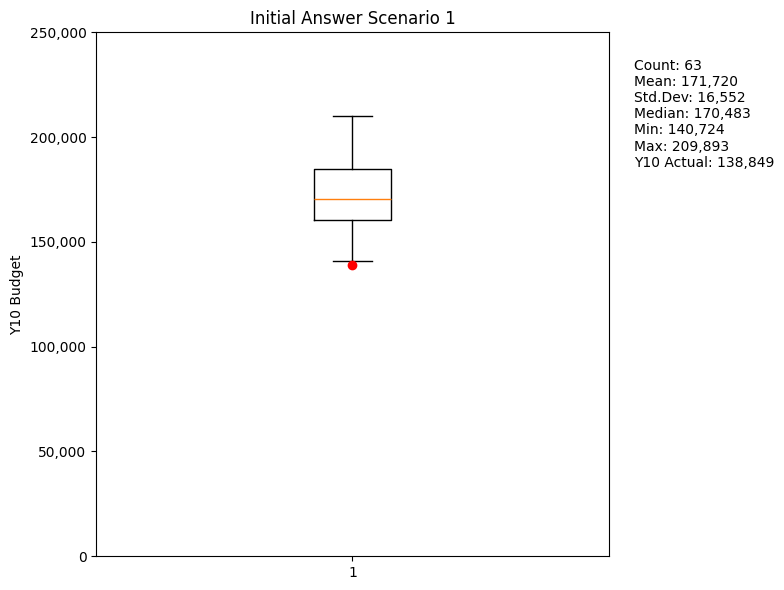

In [26]:
# Prepare data for boxplot
data_to_plot = [nonaicon_df['Scenario1_Answer_1'].dropna()]
red_dot_values = [138849]  # Specified value for the red dot in the boxplot
titles = ['Initial Answer Scenario 1']

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Generate the boxplot for Scenario 1
ax.boxplot(data_to_plot)
ax.set_title(titles[0])

# Calculate statistics
count = len(data_to_plot[0])
mean = np.mean(data_to_plot[0])
std_dev = np.std(data_to_plot[0], ddof=1)  # Sample standard deviation
median = np.median(data_to_plot[0])  # Median
min_val = np.min(data_to_plot[0])  # Minimum
max_val = np.max(data_to_plot[0])  # Maximum

# Annotate the plot with the calculated statistics, including median, min, max, and Y10 Actual Expenses
stats_text = f'Count: {count:,d}\nMean: {mean:,.0f}\nStd.Dev: {std_dev:,.0f}\nMedian: {median:,.0f}\nMin: {min_val:,.0f}\nMax: {max_val:,.0f}\nY10 Actual: {red_dot_values[0]:,d}'
ax.text(1.05, 0.95, stats_text, transform=ax.transAxes, verticalalignment='top')

# Add a red dot for the specified value
ax.plot(1, red_dot_values[0], 'ro', label='Actual Expense Y10')

# Set y-axis limits
ax.set_ylim(0, 250000)

# Format y-axis with ,000 separators
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}'))

# Add y-axis label
ax.set_ylabel('Y10 Budget')

# Create a custom legend for the red dot
# ax.legend(handles=[red_dot], loc="upper center", bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

plt.tight_layout()
plt.show()


Submission after Slack Evaluation

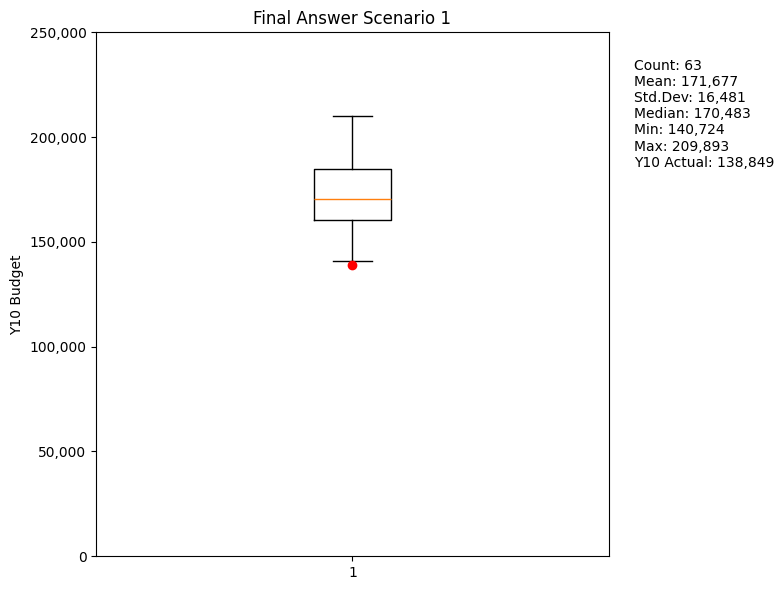

In [27]:
# Prepare data for boxplot
data_to_plot = [nonaicon_df['Scenario1_FinalAnswer'].dropna()]
red_dot_values = [138849]  # Specified value for the red dot in the boxplot
titles = ['Final Answer Scenario 1']

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(8, 6))

# Generate the boxplot for Scenario 1
ax.boxplot(data_to_plot)
ax.set_title(titles[0])

# Calculate statistics
count = len(data_to_plot[0])
mean = np.mean(data_to_plot[0])
std_dev = np.std(data_to_plot[0], ddof=1)  # Sample standard deviation
median = np.median(data_to_plot[0])  # Median
min_val = np.min(data_to_plot[0])  # Minimum
max_val = np.max(data_to_plot[0])  # Maximum

# Annotate the plot with the calculated statistics, including median, min, max, and Y10 Actual Expenses
stats_text = f'Count: {count:,d}\nMean: {mean:,.0f}\nStd.Dev: {std_dev:,.0f}\nMedian: {median:,.0f}\nMin: {min_val:,.0f}\nMax: {max_val:,.0f}\nY10 Actual: {red_dot_values[0]:,d}'
ax.text(1.05, 0.95, stats_text, transform=ax.transAxes, verticalalignment='top')

# Add a red dot for the specified value
ax.plot(1, red_dot_values[0], 'ro', label='Actual Expense Y10')

# Set y-axis limits
ax.set_ylim(0, 250000)

# Format y-axis with ,000 separators
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:,.0f}'))

# Add y-axis label
ax.set_ylabel('Y10 Budget')

# Create a custom legend for the red dot
# ax.legend(handles=[red_dot], loc="upper center", bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3)

plt.tight_layout()
plt.show()


#### Resubmissions

In [28]:
# Define the combined conditions and their corresponding resubmission columns for NoAI and AI
conditions = {
    'AI': ('FL_74', ['AI_Resubmission13_1']),
    'NonAI': ('FL_76', ['NoAI_Resubmission13_1']),
}

In [29]:
# Initialize the results list
results = []

# Scenario column for comparison
scenario_answer_column = 'Scenario1_Answer_1'

# Iterate through the conditions
for condition, (do_type, resub_columns) in conditions.items():
    # Filter DataFrame based on FL_23_DO
    condition_filter = completed_survey_df["FL_23_DO"] == do_type
    count_of_condition = completed_survey_df[condition_filter].shape[0]
    
    # Iterate through resubmission columns for each condition
    for resub_column in resub_columns:
        # Filter rows with valid numeric values for the current resubmission column and scenario answer
        valid_rows_filter = condition_filter & completed_survey_df[resub_column].notna() & completed_survey_df[scenario_answer_column].notna()
        
        # Ensure numeric types for calculation
        completed_survey_df.loc[valid_rows_filter, resub_column] = pd.to_numeric(completed_survey_df.loc[valid_rows_filter, resub_column], errors='coerce')
        completed_survey_df.loc[valid_rows_filter, scenario_answer_column] = pd.to_numeric(completed_survey_df.loc[valid_rows_filter, scenario_answer_column], errors='coerce')
        
        # Calculate the difference and mean difference for rows with valid data
        if valid_rows_filter.any():
            differences = completed_survey_df.loc[valid_rows_filter, resub_column] - completed_survey_df.loc[valid_rows_filter, scenario_answer_column]
            mean_difference = differences.mean()
        else:
            mean_difference = None
        
        count_with_value = valid_rows_filter.sum()
        percentage_resubmission_rate = (count_with_value / count_of_condition) * 100 if count_of_condition else 0
        
        # Append the results
        results.append({
            'Condition': condition,
            'Scenario': scenario_answer_column,
            'Count of Condition': count_of_condition,
            'Number of Resubmissions': count_with_value,
            '% Resubmission Rate': percentage_resubmission_rate,
            'Mean Slack Reduction': mean_difference
        })

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Optionally, round the values for display
results_df['Mean Slack Reduction'] = results_df['Mean Slack Reduction'].round(2)
results_df['% Resubmission Rate'] = results_df['% Resubmission Rate'].round(2)

# Display the table
results_df


,Condition,Scenario,Count of Condition,Number of Resubmissions,% Resubmission Rate,Mean Slack Reduction
0,AI,Scenario1_Answer_1,55,13,23.64,-15694.08
1,NonAI,Scenario1_Answer_1,63,1,1.59,-2681.00


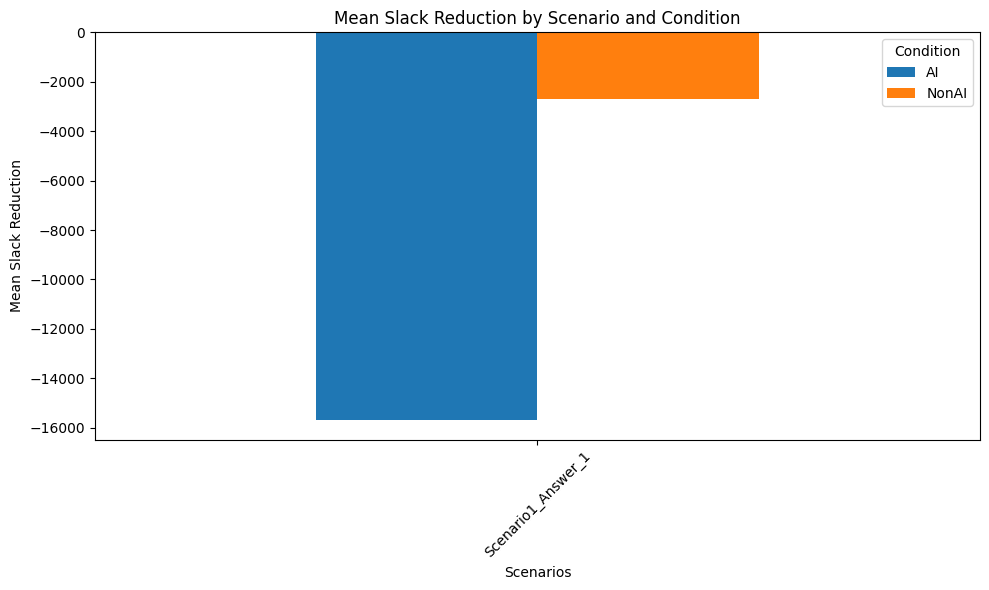

In [30]:
# Pivot the DataFrame to make it suitable for plotting
pivot_df = results_df.pivot(index='Scenario', columns='Condition', values='Mean Slack Reduction')

# Plot the bar chart from the pivoted DataFrame
pivot_df.plot(kind='bar', figsize=(10, 6))

# Set the titles and labels
plt.title('Mean Slack Reduction by Scenario and Condition')
plt.xlabel('Scenarios')
plt.ylabel('Mean Slack Reduction')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

# Show the plot
plt.legend(title='Condition')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


## 5. Randomization Checks

In [31]:
# # Filter the column "Sex" where values are not null
# sex_not_null = completed_survey_df.loc[completed_survey_df['FL_23_DO'].notnull(), 'FL_23_DO']

# # Print the resulting column
# print(sex_not_null)


In [32]:
# Set index of filtered_demographics_df to match the index of completed_survey_df
filtered_demographics_df.set_index(completed_survey_df.index, inplace=True)

# Merge the DataFrames on their indices
completed_survey_df = pd.merge(completed_survey_df, filtered_demographics_df[['Age', 'Sex']], left_index=True, right_index=True, how='left')

# Print the updated DataFrame
len(completed_survey_df)

118

In [33]:
# # Filter the column "Sex" where values are not null
# sex_not_null = completed_survey_df.loc[completed_survey_df['FL_23_DO'].notnull(), 'FL_23_DO']

# # Print the resulting column
# print(sex_not_null)


#### Age (t-test)

There is still some result deviance with Excel (currently trying to fix this)

In [34]:
# Filter rows where FL_23_DO equals FL_74
aicon_age = completed_survey_df[completed_survey_df['FL_23_DO'] == 'FL_74']['Age'].dropna()

# Take all rows in completed_survey_df for FL_76 as the population
nonaicon_age = completed_survey_df[completed_survey_df['FL_23_DO'] == 'FL_76']['Age'].dropna()

# Calculate mean and variance for aicon_age
aicon_age_mean = aicon_age.mean()
aicon_age_var = aicon_age.var()
aicon_age_count = aicon_age.count()  # Count of non-NaN values

# Calculate mean and variance for nonaicon_age
nonaicon_age_mean = nonaicon_age.mean()
nonaicon_age_var = nonaicon_age.var()
nonaicon_age_count = nonaicon_age.count()  # Count of non-NaN values

# Print statistics for 'aicon_age' with count
print("Statistics for 'aicon_age':")
print(f"Mean: {aicon_age_mean}, Variance: {aicon_age_var}, Count: {aicon_age_count}")

print("\nStatistics for 'nonaicon_age':")
print(f"Mean: {nonaicon_age_mean}, Variance: {nonaicon_age_var}, Count: {nonaicon_age_count}")

# Perform the t-test
t_stat, p_value = stats.ttest_ind(aicon_age, nonaicon_age, equal_var=False)  # equal_var=False for Welch's t-test
print(f"\nT-statistic: {t_stat}, P-value: {p_value}")


Statistics for 'aicon_age':
Mean: 40.25454545454546, Variance: 163.3043771043771, Count: 55

Statistics for 'nonaicon_age':
Mean: 41.07936507936508, Variance: 140.62263184843832, Count: 63

T-statistic: -0.3616629710088258, P-value: 0.7182911425015757


#### Work Experience (t-test)

In [35]:
# Filter rows where FL_23_DO equals FL_74
aicon_workexp = completed_survey_df[completed_survey_df['FL_23_DO'] == 'FL_74']['WorkExp_1'].dropna()

# Take all rows in completed_survey_df for FL_76 as the population
nonaicon_workexp = completed_survey_df[completed_survey_df['FL_23_DO'] == 'FL_76']['WorkExp_1'].dropna()

# Calculate mean and variance for aicon_workexp
aicon_workexp_mean = aicon_workexp.mean()
aicon_workexp_var = aicon_workexp.var()
aicon_workexp_count = aicon_workexp.count()  # Count of non-NaN values

# Calculate mean and variance for nonaicon_workexp
nonaicon_workexp_mean = nonaicon_workexp.mean()
nonaicon_workexp_var = nonaicon_workexp.var()
nonaicon_workexp_count = nonaicon_workexp.count()  # Count of non-NaN values

# Print statistics for 'aicon_workexp' with count
print("Statistics for 'aicon_workexp':")
print(f"Mean: {aicon_workexp_mean}, Variance: {aicon_workexp_var}, Count: {aicon_workexp_count}")

print("\nStatistics for 'nonaicon_workexp':")
print(f"Mean: {nonaicon_workexp_mean}, Variance: {nonaicon_workexp_var}, Count: {nonaicon_workexp_count}")

# Perform the t-test
t_stat, p_value = stats.ttest_ind(aicon_workexp, nonaicon_workexp, equal_var=False)  # equal_var=False for Welch's t-test
print(f"\nT-statistic: {t_stat}, P-value: {p_value}")


Statistics for 'aicon_workexp':
Mean: 18.418181818181818, Variance: 130.9144781144781, Count: 55

Statistics for 'nonaicon_workexp':
Mean: 18.53968253968254, Variance: 122.57501280081927, Count: 63

T-statistic: -0.05841719519251943, P-value: 0.9535197286027035


#### Gender (Chi-square)

For some reason, it counts one Male as Female in the FL_74 col and one Female as Male in the FL_76 col (still trying to fix this)

In [36]:
# Filter the DataFrame to include only the rows for 'Male' and 'Female' groups
filtered_df = completed_survey_df[completed_survey_df['Sex'].isin(['Male', 'Female'])]

# Pivot the table to have 'Sex' as index and 'Condition' as columns, count occurrences
contingency_table = filtered_df.groupby(['Sex', 'FL_23_DO']).size().unstack(fill_value=0)

# Select only the desired columns and rows to get the final table with 4 cells
final_table = contingency_table[['FL_74', 'FL_76']].loc[['Male', 'Female']]

# Drop the index
final_table = final_table.reset_index()

# Print the final table
print(final_table)

FL_23_DO     Sex  FL_74  FL_76
0           Male     20     23
1         Female     34     40


In [37]:
# Calculate the Chi-squared test without Yates' correction
chi2, p, dof, expected = chi2_contingency(final_table.set_index('Sex'), correction=False)

print(f"\nChi-squared Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies: \n{expected}")

# Number of observations
n = np.sum(contingency_table)

# Minimum dimension of the table minus 1 (min(n_rows - 1, n_cols - 1))
min_dim = min(contingency_table.shape) - 1

# Calculate Cramer's V
cramers_v = np.sqrt(chi2 / (n * min_dim))

print(f"\nCramer's V: {cramers_v}")


Chi-squared Statistic: 0.003501840711143012
P-value: 0.9528116444915016
Degrees of Freedom: 1
Expected Frequencies: 
[[19.84615385 23.15384615]
 [34.15384615 39.84615385]]

Cramer's V: FL_23_DO
FL_74    0.008053
FL_76    0.007456
dtype: float64


C:\Users\domin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


## 6. Hypotheses Testing

#### H2: “Practitioners are more likely to revise their initial budget after an AI evaluation message, compared to the Non-AI evaluation message.”

In [38]:
# Filter the DataFrame to include only the rows for 'AI' and 'NonAI' groups
filtered_df = results_df[results_df['Condition'].isin(['AI', 'NonAI'])]

# Now, construct the contingency table. 
# Assuming 'Count of Condition' and 'Number of Resubmissions' are the columns of interest
contingency_table = filtered_df[['Count of Condition', 'Number of Resubmissions']].values

# Calculate the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-squared Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies: \n{expected}")

Chi-squared Statistic: 8.945113320752032
P-value: 0.00278212834810419
Degrees of Freedom: 1
Expected Frequencies: 
[[60.78787879  7.21212121]
 [57.21212121  6.78787879]]


Note (rationale for the different chi-squared results here and in Excel): The stats.chi2_contingency function from SciPy does more than just perform the straightforward calculation we did. Specifically, it includes adjustments for small sample sizes or when the expected frequencies in some cells of the contingency table are below a certain threshold (commonly 5). This is known as the Yates' correction for continuity, or more broadly, could involve other corrections or adjustments based on the characteristics of the data to ensure the accuracy and reliability of the test's results. See https://en.wikipedia.org/wiki/Yates%27s_correction_for_continuity for more

The following results avoid this automated correction and yield the same results as in Excel:

In [39]:
# Calculate the Chi-squared test without Yates' correction
chi2, p, dof, expected = chi2_contingency(contingency_table, correction=False)

print(f"Chi-squared Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies: \n{expected}")

Chi-squared Statistic: 10.7167159236576
P-value: 0.001061719493395608
Degrees of Freedom: 1
Expected Frequencies: 
[[60.78787879  7.21212121]
 [57.21212121  6.78787879]]


In [40]:
# Calculate the Chi-squared test without Yates' correction
chi2, p, dof, expected = chi2_contingency(contingency_table, correction=False)

# Number of observations
n = np.sum(contingency_table)

# Minimum dimension of the table minus 1 (min(n_rows - 1, n_cols - 1))
min_dim = min(contingency_table.shape) - 1

# Calculate Cramer's V
cramers_v = np.sqrt(chi2 / (n * min_dim))

print(f"Cramer's V: {cramers_v}")

Cramer's V: 0.28493374992424275


In [41]:
# Calculate the Chi-squared test without Yates' correction
chi2, p, dof, expected = chi2_contingency(contingency_table, correction=False)

# Number of observations (total sample size)
n = np.sum(contingency_table)

# Calculate Phi
phi = np.sqrt(chi2 / n)

print(f"Phi: {phi}")

Phi: 0.28493374992424275


#### H3: “The extent of budgetary slack reduction after the AI evaluation is larger than after the Non-AI evaluation.”

In [42]:
# Add a new column "Slack" to completed_survey_df
completed_survey_df['Slack'] = completed_survey_df['Scenario1_FinalAnswer'] - (138849) # 138849 was the ML model forecast

# Filter the DataFrame to keep only rows where Slack is 0 or positive
h2_df = completed_survey_df[completed_survey_df['Slack'] >= 0]

# Count the number of rows where Slack is greater than or equal to 0
slack_positive_count = (h2_df['Slack'] >= 0).sum()

print(f"Number of rows where Slack is greater than or equal to 0: {slack_positive_count}")



Number of rows where Slack is greater than or equal to 0: 118


Absolute Slack Reduction

In [43]:
# Add a new column "Slack Reduction" to h2_df using .loc
h2_df.loc[:, 'Slack Reduction'] = h2_df['Scenario1_Answer_1'] - h2_df['Scenario1_FinalAnswer']

# Filter the DataFrame to keep only rows where "Slack Reduction" is greater than or equal to 0
h2_df = h2_df[h2_df['Slack Reduction'] >= 0]

# Print the count of rows remaining after filtering
rows_left = len(h2_df)
print(f"Number of rows remaining after filtering: {rows_left}")


Number of rows remaining after filtering: 118


In [44]:
# Filter rows where FL_23_DO equals FL_74
aicon_final = h2_df[h2_df['FL_23_DO'] == 'FL_74']['Slack Reduction'].dropna()

# Take all rows in completed_survey_df for Scenario1_Answer_1 as the population
nonaicon_final = h2_df[h2_df['FL_23_DO'] == 'FL_76']['Slack Reduction'].dropna()

# Perform the t-test
t_stat, p_value = stats.ttest_ind(aicon_final, nonaicon_final, equal_var=False)  # equal_var=False for Welch's t-test

print(f"T-statistic: -{t_stat}, P-value: {p_value}")

T-statistic: -3.0802807766041624, P-value: 0.0032467345107444626


In [45]:
# Calculate mean and standard deviation for aicon_final
aicon_final_mean = aicon_final.mean()
aicon_final_std = aicon_final.std()

# Calculate mean and standard deviation for nonaicon_final
nonaicon_final_mean = nonaicon_final.mean()
nonaicon_final_std = nonaicon_final.std()

# Print the results
print(f"Mean for aicon_final: -{aicon_final_mean}")
print(f"Standard Deviation for aicon_final: {aicon_final_std}")
print(f"Mean for nonaicon_final: -{nonaicon_final_mean}")
print(f"Standard Deviation for nonaicon_final: {nonaicon_final_std}")


Mean for aicon_final: -3709.509090909091
Standard Deviation for aicon_final: 8823.050918690467
Mean for nonaicon_final: -42.55555555555556
Standard Deviation for nonaicon_final: 337.7742507125794


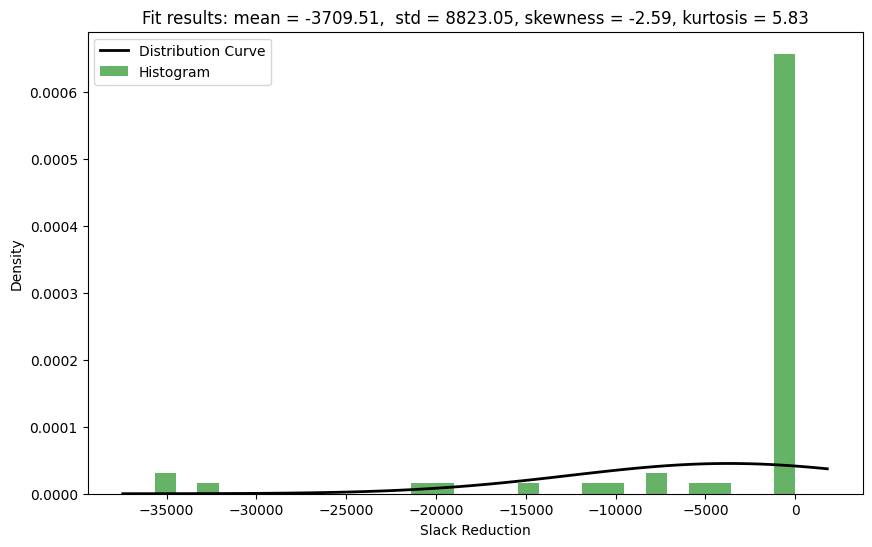

In [46]:
# Assuming aicon_final is a pandas Series. If it's not, adjust the code accordingly.

# Make all values negative for visualization
aicon_final_negative = -abs(aicon_final)

# Calculate statistics on the transformed (negative) data
mean = aicon_final_negative.mean()
std = aicon_final_negative.std()
skewness = skew(aicon_final_negative)
kurt = kurtosis(aicon_final_negative)

# Generate histogram for the transformed aicon_final values
plt.figure(figsize=(10, 6))
count, bins, ignored = plt.hist(aicon_final_negative, bins=30, density=True, alpha=0.6, color='g')

# Add a distribution curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p, 'k', linewidth=2)

title = "Fit results: mean = %.2f,  std = %.2f, skewness = %.2f, kurtosis = %.2f" % (mean, std, skewness, kurt)
plt.title(title)
plt.xlabel('Slack Reduction')
plt.ylabel('Density')

plt.legend(['Distribution Curve', 'Histogram'])
plt.show()


Relative Slack Reduction

In [47]:
# Add a new column "Slack Reduction" to h2_df using .loc
h2_df.loc[:, 'Slack Reduction in %'] = h2_df['Slack Reduction'] / h2_df['Scenario1_Answer_1']

# Filter the DataFrame to keep only rows where "Slack Reduction" is greater than or equal to 0
h2_df = h2_df[h2_df['Slack Reduction in %'] >= 0]

# Print the count of rows remaining after filtering
rows_left = len(h2_df)
print(f"Number of rows remaining after filtering: {rows_left}")


Number of rows remaining after filtering: 118


In [48]:
# Filter rows where FL_23_DO equals FL_74
aicon_final = h2_df[h2_df['FL_23_DO'] == 'FL_74']['Slack Reduction in %'].dropna()

# Take all rows in completed_survey_df for Scenario1_Answer_1 as the population
nonaicon_final = h2_df[h2_df['FL_23_DO'] == 'FL_76']['Slack Reduction in %'].dropna()

# Perform the t-test
t_stat, p_value = stats.ttest_ind(aicon_final, nonaicon_final, equal_var=False)  # equal_var=False for Welch's t-test

print(f"T-statistic: -{t_stat}, P-value: {p_value}")

T-statistic: -3.181054655574531, P-value: 0.002429858018609286


In [49]:
# Calculate mean and standard deviation for aicon_final
aicon_final_mean = aicon_final.mean()
aicon_final_std = aicon_final.std()

# Calculate mean and standard deviation for nonaicon_final
nonaicon_final_mean = nonaicon_final.mean()
nonaicon_final_std = nonaicon_final.std()

# Print the results
print(f"Mean for aicon_final: -{aicon_final_mean}")
print(f"Standard Deviation for aicon_final: {aicon_final_std}")
print(f"Mean for nonaicon_final: -{nonaicon_final_mean}")
print(f"Standard Deviation for nonaicon_final: {nonaicon_final_std}")


Mean for aicon_final: -0.019813744305857407
Standard Deviation for aicon_final: 0.04567041034249356
Mean for nonaicon_final: -0.00021252168914236123
Standard Deviation for nonaicon_final: 0.0016868386130341909


### Fig 4

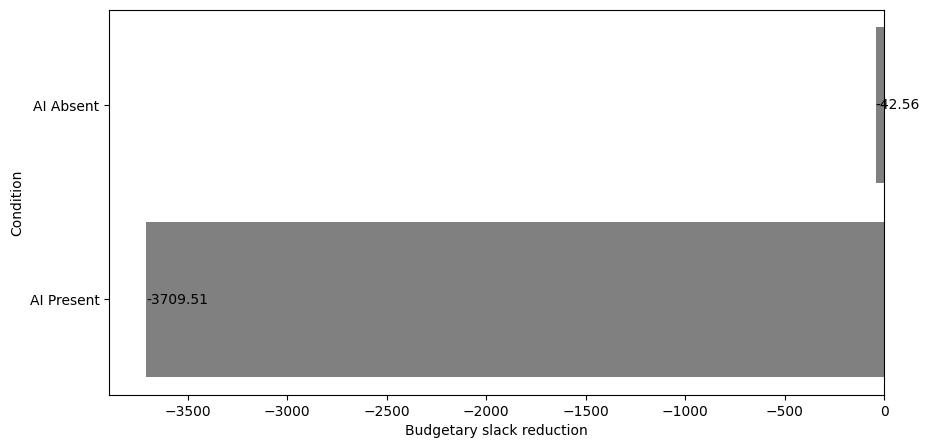

In [50]:
import matplotlib.pyplot as plt

# Data
conditions = ['AI Present', 'AI Absent']
means = [-3709.509, -42.556]

# Create horizontal bar chart
plt.figure(figsize=(10, 5))
plt.barh(conditions, means, color='gray')
plt.xlabel('Budgetary slack reduction')  # Set the x-axis label
plt.ylabel('Condition')       # Set the y-axis label
# plt.title('Mean Values for AI Presence')  # Optionally adding a title if you later decide you want one
for index, value in enumerate(means):
    plt.text(value, index, f'{value:.2f}', va='center')

# Show the plot
plt.show()
